In [286]:
#Imports
import random
import math
import matplotlib.pyplot as plt
import scipy as sp
# import sklearn
import sklearn.datasets
import sklearn.decomposition
from sklearn.utils import Bunch
import numpy as np
import pandas as pd
from functools import cmp_to_key
from itertools import combinations

## Abstract Data Type

In [287]:
#definição do tipo abstrato Point
class Point:
	def __init__(self, x, y):
		self.x = x
		self.y = y

	def __str__(self):
		return f'({self.x}, {self.y}) ' #auxiliar para imprimir o ponto e conferir se as funções estão corretas

	def __repr__(self):
		return str(self)

	def __lt__(self, other):
		if self.x < other.x:
			return True
		elif self.x == other.x:
			if self.y < other.y:
				return True
		return False


#definição do tipo abstrato Segment contendo 2 pontos e os coeficientes a e b da reta
class Segment:
	def __init__(self, p1, p2):
		self.p1 = p1
		self.p2 = p2
		if p1.x == p2.x:
			p2.x += 0.0001
		self.a = (p2.y - p1.y)/(p2.x - p1.x)
		self.b = p1.y - self.a*p1.x

	def __str__(self):
		return f'({self.p1}, {self.p2})' #auxiliar para imprimir o segmento e conferir se as funções estão corretas

	def __repr__(self):
		return str(self)

	def __lt__(self, other):
		thisY = self.a * other.p1.x + self.b
		otherY = other.a * self.p1.x + other.b
		if self.p1.x < other.p1.x:
			if thisY < other.p1.y:
				return True
		elif self.p1.x == other.p1.x:
			if self.p1.y < other.p1.y:
				return True
		else:
			if self.p1.y < otherY:
				return True
		return False

	def __gt__(self, other):
		thisY = self.a * other.p1.x + self.b
		otherY = other.a * self.p1.x + other.b
		if self.p1.x < other.p1.x:
			if thisY > other.p1.y:
				return True
		elif self.p1.x == other.p1.x:
			if self.p1.y > other.p1.y:
				return True
		else:
			if self.p1.y > otherY:
				return True


#definição do tipo abstrato EndPoint contendo um ponto, ponteiro para o seguimento, e uma flag para saber se é o ponto inicial ou final do seguimento
class EndPoint:
	def __init__(self, point, segment, isLeft):
		self.point = point
		self.segment = segment
		self.isLeft = isLeft

	def __str__(self):
		return f'({self.point}, {self.segment}, {self.isLeft}) '

	def __repr__(self):
		return str(self)

	def __lt__(self, other):
		if self.point.x < other.point.x:
			return True
		elif self.point.x == other.point.x:
			if self.isLeft and not other.isLeft:
				return True
			elif not self.isLeft and other.isLeft:
				return False
			elif self.point.y < other.point.y:
				return True
		return False

#Globals
anchor = Point(0,0)

In [288]:
#ÁRVORE AVL

#definição do tipo abstrato TreeNode
class TreeNode(object):
	def __init__(self, value):
		self.value = value
		self.left = None
		self.right = None
		self.height = 1

	def __str__(self):
		return f'({self.value})'

	def __repr__(self):
		return str(self)

#implementação da árvore
class AVLTree(object):
	def insert(self, node, value):
		if not node:
			return TreeNode(value)
		elif value < node.value:
			node.left = self.insert(node.left, value)
		else:
			node.right = self.insert(node.right, value)
		node = self.balance(node) # balance the tree everytime a new node is inserted
		return node

	def balance(self, node):
		node = self.refreshHeight(node) # update the height of the node
		balanceFactor = self.getBalanceFactor(node) # check whether the node is unbalanced, and if so, if it has to be rotated to the left or to the right
		if balanceFactor < -1:
			if self.getBalanceFactor(node.left) > 0:
				node.left = self.rotateLeft(node.left)
			node = self.rotateRight(node)
		elif balanceFactor > 1:
			if self.getBalanceFactor(node.right) < 0:
				node.right = self.rotateRight(node.right)
			node = self.rotateLeft(node)
		return node

	def remove(self, node, value):
		if not node:
			return node
		elif value < node.value:
			node.left = self.remove(node.left, value)
		elif value > node.value:
			node.right = self.remove(node.right, value)
		else:
			if node.left is None:
				temp = node.right
				node = None
				return temp
			elif node.right is None:
				temp = node.left
				node = None
				return temp
			temp = self.getMinValue(node.right)
			node.value = temp.value
			node.right = self.remove(node.right, temp.value)
		if node is None:
			return node

		node = self.refreshHeight(node)
		node = self.balance(node)
		return node

	def getMinValue(self, node):
		if node is None or node.left is None:
			return node
		return self.getMinValue(node.left)

	def refreshHeight(self, node):
		node.height = max(self.getHeight(node.left), self.getHeight(node.right)) + 1 # height of a node is the maximum height of its children plus 1
		return node

	def getHeight(self, node):
		if not node:
			return 0 # height of an empty node is 0
		return node.height

	def getBalanceFactor(self, node):
		if not node:
			return 0 # balance factor of an empty node is 0
		return self.getHeight(node.right) - self.getHeight(node.left) # balance factor of a node is the height of its right child minus the height of its left child

	def preOrder(self, node):
		if not node:
			return
		print(node.value, node.height)
		self.preOrder(node.left)
		self.preOrder(node.right)

	def inOrder(self, node):
		if not node:
			return
		self.inOrder(node.left)
		print(node.value, node.height)
		self.inOrder(node.right)

	def rotateLeft(self, node):
		aux = node.right
		node.right = aux.left
		aux.left = node
		aux = self.refreshHeight(aux)
		node = self.refreshHeight(node)
		return aux

	def rotateRight(self, node):
		aux = node.left
		node.left = aux.right
		aux.right = node
		aux = self.refreshHeight(aux)
		node = self.refreshHeight(node)
		return aux

	def above(self, node, value):
		above = None
		while node != None:
			if node.value > value:
				above = node
				node = node.left
			else:
				node = node.right
		return above

	def below(self, node, value):
		below = None
		while node != None:
			if node.value < value:
				below = node
				node = node.right
			else:
				node = node.left
		return below

	# Auxiliary function to get the arrays necessary to plot the tree
	def getArraysForVisualization(self, node, x, y, xStep):
		treeArray = []
		valArray = []
		closeFamily = []
		if not node:
			return [], [], []

		thisFamily = []
		thisFamily.append(node.value)
		if node.left:
			thisFamily.append(node.left.value)
		else:
			thisFamily.append(None)
		if node.right:
			thisFamily.append(node.right.value)
		else:
			thisFamily.append(None)

		closeFamily.append(thisFamily)

		treeArray.append((x, y))
		valArray.append(node.value)

		treeAux, valAux, famAux = self.getArraysForVisualization(node.left, x - xStep, y - 1, xStep / 1.4)
		treeArray += treeAux
		valArray += valAux
		closeFamily += famAux

		treeAux, valAux, famAux = self.getArraysForVisualization(node.right, x + xStep, y - 1, xStep / 1.4)
		treeArray += treeAux
		valArray += valAux
		closeFamily += famAux
		return treeArray, valArray, closeFamily

	# Plot the tree
	def visualizeTree(self, node):
		if node == None:
			return None
		treeArray, valArray, closeFamily = Tree.getArraysForVisualization(node, 0, 0, 8)

		x = [point[0] for point in treeArray]
		y = [point[1] for point in treeArray]
		plt.scatter(x, y, marker='o', color='blue', label='Pontos')
		plt.title('AVL Tree')
		for i in range(len(x)):
			plt.text(x[i], y[i], valArray[i], ha='center', va='bottom', position=(x[i], y[i] + 0.1))

		plt.axis('off')

		# set range for x and y axes
		plt.ylim(min(y) - 1, max(y) + 1)
		plt.xlim(min(x) - 1, max(x) + 1)

		for i in closeFamily:
			parentIndex = valArray.index(i[0])
			if i[1] != None:
				leftChildIndex = valArray.index(i[1])
				plt.plot([x[parentIndex], x[leftChildIndex]], [y[parentIndex], y[leftChildIndex]], marker='o', color='blue')
			if i[2] != None:
				rightChildIndex = valArray.index(i[2])
				plt.plot([x[parentIndex], x[rightChildIndex]], [y[parentIndex], y[rightChildIndex]], marker='o', color='blue')
		return plt

## Utility Functions

In [289]:
#definir distância entre os pontos p e q
def getDistance(p, q):
	return math.sqrt((p.x - q.x) ** 2 + (p.y - q.y) ** 2)

#calcular o produto vetorial para definir uma orientação
def getDirection(sp1, sp2, p):
	return ((sp2.y - sp1.y) * (p.x - sp2.x) - (sp2.x - sp1.x) * (p.y - sp2.y))

#define a orientação de pontos a partir da âncora
def getOrientation(sp1, sp2, p):
	product = getDirection(sp1, sp2, p)

	if product > 0:
		return 1  # giro a direita
	elif product < 0:
		return -1  # giro a esquerda
	else:
		return 0  # colineares

#comparar os pontos p e q para definir ordenação em relação ao angulo polar a partir da âncora
def comparePoints(p, q):
	orientation = getOrientation(anchor, p, q)
	if orientation == 0:
		if getDistance(anchor, q) >= getDistance(anchor, p):
			return -1
		else:
			return 1
	else:
		if orientation == -1:
			return -1
		else:
			return 1

#definir a âncora para uso no algoritmo de Graham
def findAnchor(points):
	anchorIndex = 0
	for i in range(1, len(points)):
		if points[i].y < points[anchorIndex].y or (points[i].y == points[anchorIndex].y and points[i].x < points[anchorIndex].x):
			anchorIndex = i
	anchor = points[anchorIndex]
	points.pop(anchorIndex)
	return anchor, points

#define se o ponto está em um seguimento
def isOnSegment(sp1, sp2, p):
	if (p.x <= max(sp1.x, sp2.x) and p.x >= min(sp1.x, sp2.x) and p.y <= max(sp1.y, sp2.y) and p.y >= min(sp1.y, sp2.y)):
		return True
	return False

#encontrar interseções entre duas retas
def segmentsIntersect(s1p1, s1p2, s2p1, s2p2):
	d1 = getOrientation(s2p1, s2p2, s1p1)
	d2 = getOrientation(s2p1, s2p2, s1p2)
	d3 = getOrientation(s1p1, s1p2, s2p1)
	d4 = getOrientation(s1p1, s1p2, s2p2)
	if (s1p2.x == s2p1.x) and (s1p2.y == s2p1.y):
		return False
	if (s1p1.x == s2p2.x) and (s1p1.y == s2p2.y):
		return False
	if((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
		return True
	elif d1 == 0 and isOnSegment(s2p1, s2p2, s1p1):
		return True
	elif d2 == 0 and isOnSegment(s2p1, s2p2, s1p2):
		return True
	elif d3 == 0 and isOnSegment(s1p1, s1p2, s2p1):
		return True
	elif d4 == 0 and isOnSegment(s1p1, s1p2, s2p2):
		return True
	return False

#define um array de endpoints de um conjunto de segmentos
def getEndpointArray(s):
	p = []
	lp = []
	rp = []
	for i in s:
		lep = None
		rep = None
		if i.p1 < i.p2:
			lep = EndPoint(i.p1, i, True)
			rep = EndPoint(i.p2, i, False)
		else:
			lep = EndPoint(i.p2, i, True)
			rep = EndPoint(i.p1, i, False)
		lp.append(lep)
		rp.append(rep)
	lp.sort()
	rp.sort()
	li = 0
	ri = 0
	while len(p) < len(lp) + len(rp):
		if li == len(lp):
			p.append(rp[ri])
			ri += 1
		elif ri == len(rp):
			p.append(lp[li])
			li += 1
		elif lp[li] < rp[ri]:
			p.append(lp[li])
			li += 1
		else:
			p.append(rp[ri])
			ri += 1
	return p

#definir os segmentos das envoltórias como uma tupla de pontos
def getConvexHullSegment(hull1):
	n = len(hull1)

	segments1 = []

	for i in range(n):
		point = hull1[i]
		nextPoint = hull1[(i + 1) % n]
		segments1.append(Segment(point, nextPoint))

	return segments1

## Graham

In [290]:
def getConvexHull(points):
	n = len(points)

	#encontrar a âncora
	anch, points = findAnchor(points)
	global anchor
	anchor = anch

	#ordenar os pontos
	sortedPoints = sorted(points, key=cmp_to_key(comparePoints))
	sortedPoints = [anchor] + sortedPoints

	#definição da pilha que conterá a solução da envoltória convexa
	hullPoints = [sortedPoints[0], sortedPoints[1], sortedPoints[2]]
	pointsInside = []

	#atualização dos pontos na pilha
	for i in range(3, n):
		while ((len(hullPoints) > 1) and (getOrientation(hullPoints[-2], hullPoints[-1], sortedPoints[i]) != -1)):
			hullPoints.pop()
			pointsInside.append(sortedPoints[i - 1])
		hullPoints.append(sortedPoints[i])

	segments = getConvexHullSegment(hullPoints)

	hull = ConvexHull(hullPoints, pointsInside, segments)

	return hull

## Line Sweeping

In [291]:
def lineSweep(segments):
	p = getEndpointArray(segments) # Array de endpoints
	t = AVLTree() # Árvore para ordenação
	root = None
	for i in p:
		if i.isLeft: # Pontos iniciais são adicionados na árvore
			root = t.insert(root, i.segment)
			above = t.above(root, i.segment)
			if above != None:
				if segmentsIntersect(i.segment.p1, i.segment.p2, above.value.p1, above.value.p2): # Se o segmento do ponto inicial intersecta com o segmento acima, retorna True
					return True
			below = t.below(root, i.segment)
			if below != None:
				if segmentsIntersect(i.segment.p1, i.segment.p2, below.value.p1, below.value.p2): # Se o segmento do ponto inicial intersecta com o segmento abaixo, retorna True
					return True
		else: # Pontos finais são removidos da árvore
			above = t.above(root, i.segment)
			below = t.below(root, i.segment)
			if above != None and below != None:
				if segmentsIntersect(above.value.p1, above.value.p2, below.value.p1, below.value.p2): # Se o segmento acima intersecta com o segmento abaixo, retorna True
					return True
			root = t.remove(root, i.segment)
	return False

## Model Functions

In [292]:
#encontrar os dois pontos mais próximos entre as envoltórias
def getClosestPointsFromConvexHulls(hull1, hull2):
	hull1Points = hull1.points
	hull2Points = hull2.points
	minDistance = getDistance(hull1Points[0], hull2Points[0])
	p1, p2 = hull1Points[0], hull2Points[0]

	for p in hull1Points:
		for q in hull2Points:
			d = getDistance(p, q)
			if d < minDistance:
				minDistance = d
				p1, p2 = p, q

	return p1, p2

#definir reta perpendicular que passa pelo ponto médio do segmento formado pelos dois pontos mais próximos das envoltórias
def getPerpendicularLine(p1, p2, midpoint):
	segment = Segment(p1, p2)

	#parâmetros da reta perpendicular que será o modelo de classificação dos pontos
	a = -1 / segment.a
	b = midpoint.y - a * midpoint.x

	return a, b

# Plotting

In [293]:
#plotar um conjunto de segmentos
def plotSegments(segments):
	x = [[s.p1.x, s.p2.x] for s in segments]
	y = [[s.p1.y, s.p2.y] for s in segments]

	for i in range(len(x)):
		plt.plot(x[i], y[i], marker='o', color='green')


In [294]:
def plotPoints(points, format, mSize):
	for p in points:
		plt.plot(p.x, p.y, format, markersize=mSize)

def plotPerpendicularLines(c1, c2, midpoint, perpSegment, isLinearlySeparable):
	plt.plot([c1.x, c2.x], [c1.y, c2.y], 'k-')
	
	plt.plot(midpoint.x, midpoint.y, 'ko', markersize=5)

	if isLinearlySeparable:
		plt.axline((midpoint.x, midpoint.y), slope=perpSegment.a, color='k', linestyle='-')
	else:
		plt.axline((midpoint.x, midpoint.y), slope=perpSegment.a, color='k', linestyle='--')


# Check if linearly separable

In [295]:
def checkIfHullInsideTheOther(hull1, hull2, showCombinationHull):
	combinationHull = getConvexHull(hull1.points + hull2.points)
	if showCombinationHull:
		plotSegments(combinationHull.segments)
	if combinationHull.points == hull1.points:
		return True
	elif combinationHull.points == hull2.points:
		return True
	return False

In [296]:
def getPerpendicularSegment(midpoint, aPerp, bPerp, hull1, hull2):
	hull1XMin = min([p.x for p in hull1])
	hull1XMax = max([p.x for p in hull1])
	hull2XMin = min([p.x for p in hull2])
	hull2XMax = max([p.x for p in hull2])

	aXMin = min(hull1XMin, hull2XMin)
	aXMax = max(hull1XMax, hull2XMax)

	pMin = Point(aXMin, aPerp * aXMin + bPerp)
	pMax = Point(aXMax, aPerp * aXMax + bPerp)

	return Segment(pMin, pMax)

In [297]:
class ConvexHull:
	def __init__(self, points, inside, segments):
		self.points = points
		self.inside = inside
		self.segments = segments

	def __str__(self):
		return f'({self.points}, {self.inside}, {self.segments})'

	def __repr__(self):
		return str(self)

In [298]:
class Model:
	def __init__(self, hull1, hull2, isLinearlySeparable, perpSegment, c1, c2, midpoint):
		self.hull1 = hull1
		self.hull2 = hull2
		self.isLinearlySeparable = isLinearlySeparable
		self.perpSegment = perpSegment
		self.c1 = c1
		self.c2 = c2
		self.midpoint = midpoint
		self.target = None
		self.targetName = None
		self.testing = None
		self.testingClassification = None
		self.precision = 0
		self.recall = 0
		self.f1Score = 0

	def __str__(self):
		# Plot hull1
		plotPoints(self.hull1.points, 'bo', 5)
		plotPoints(self.hull1.inside, 'bo', 2)
		for s in self.hull1.segments:
			plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], 'b-')

		# Plot hull2
		plotPoints(self.hull2.points, 'ro', 5)
		plotPoints(self.hull2.inside, 'ro', 2)
		for s in self.hull2.segments:
			plt.plot([s.p1.x, s.p2.x], [s.p1.y, s.p2.y], 'r-')

		if self.perpSegment != None:
			# Plot closest points and line perpendicular to the segment formed by them
			plotPerpendicularLines(self.c1, self.c2, self.midpoint, self.perpSegment, self.isLinearlySeparable)

		if self.testing != None:
			# Plot testing points
			for i in range(len(self.testing)):
				x = self.testing[i][0][0]
				y = self.testing[i][0][1]
				if self.testingClassification[i]:
					if self.testing[i][1] == self.target:
						plt.plot(x, y, 'co', markersize=3)
					else:
						plt.plot(x, y, 'go', markersize=3)
				else:
					if self.testing[i][1] == self.target:
						plt.plot(x, y, 'yo', markersize=3)
					else:
						plt.plot(x, y, 'mo', markersize=3)

		if type(self.targetName) != str:
			self.targetName = str(self.targetName)

		leg = plt.legend([self.targetName, 'não ' + self.targetName, 'Positivo', 'Falso Positivo', 'Falso Negativo', 'Negativo'], loc='upper right', bbox_to_anchor=(1.35, 1))
		leg.legend_handles[0].set_color('blue')
		leg.legend_handles[1].set_color('red')
		leg.legend_handles[2].set_color('cyan')
		leg.legend_handles[3].set_color('green')
		leg.legend_handles[4].set_color('yellow')
		leg.legend_handles[5].set_color('magenta')

		plt.axis('equal')

		plt.grid(True)
		plt.show()

		if not self.isLinearlySeparable:
			return 'Não linearmente separável'

		return f'(Precisão: {self.precision}, Revocação: {self.recall}, F1-Score: {self.f1Score})'

	def __repr__(self):
		return str(self)

In [299]:
def checkLinearSeparation(Target1, Target2, targetName, showCombinationHull):
	hull1 = getConvexHull(Target1)
	hull2 = getConvexHull(Target2)

	isLinearlySeparable = False
	separateHulls = False
	c1, c2 = None, None
	midpoint = None
	perpSegment = None
	s = Segment(Point(0, 0), Point(1, 1))

	linesIntercept = lineSweep(hull1.segments + hull2.segments)
	if not linesIntercept:
		separateHulls = not checkIfHullInsideTheOther(hull1, hull2, showCombinationHull)
		if separateHulls:
			c1, c2 = getClosestPointsFromConvexHulls(hull1, hull2)
			midpoint = Point((c1.x + c2.x) / 2, (c1.y + c2.y) / 2)
			aPerp, bPerp = getPerpendicularLine(c1, c2, midpoint)
			perpSegment = getPerpendicularSegment(midpoint, aPerp, bPerp, hull1.points, hull2.points)
			isLinearlySeparable = not lineSweep(hull1.segments + hull2.segments + [perpSegment])

	# plt = plotConvexHulls(hull1, hull2, isLinearlySeparable, separateHulls, c1, c2, midpoint, perpSegment, targetName)

	model = Model(hull1, hull2, isLinearlySeparable, perpSegment, c1, c2, midpoint)

	return model

## Testing

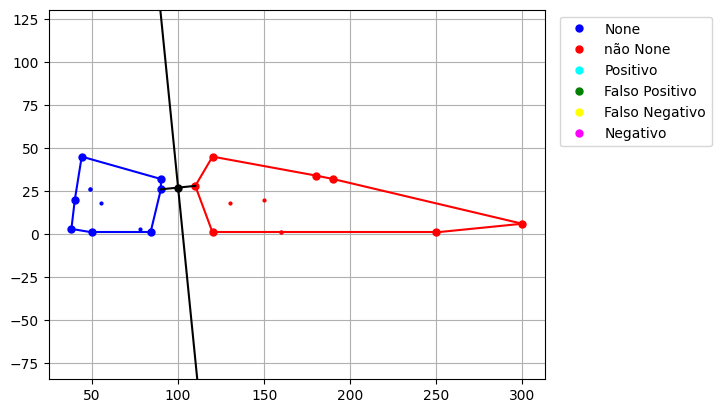

(Precisão: 0, Revocação: 0, F1-Score: 0)

In [300]:
points1 = [Point(50,1), Point(78,3), Point(40,20), Point(84,1), Point(65,33), Point(90,26), Point(49,26), Point(38,3), Point(90,32), Point(44,45), Point(55,18)]
points2 = [Point(180,34), Point(120,1), Point(120,1), Point(160,1), Point(250,1), Point(300,6), Point(110,28), Point(150,20), Point(190,32), Point(120,45), Point(130,18)]

checkLinearSeparation(points1, points2, '', False)

False

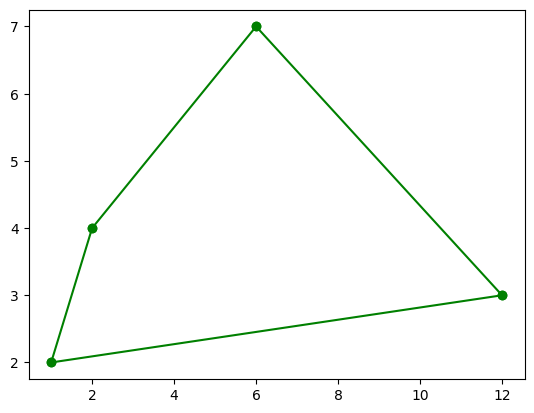

In [301]:
segtest = [Segment(Point(1, 2), Point(2, 4)), Segment(Point(2, 4), Point(6, 7)), Segment(Point(6, 7), Point(12, 3)), Segment(Point(12, 3), Point(1, 2))]
plotSegments(segtest)
lineSweep(segtest)

# Model Functions

In [302]:
#função para aplicar o modelo de classificação em um conjunto de pontos
def classifyPoints(p1, p2, points, targetOrientation):
	isTargetArray = []
	for p in points:
		orientation = getOrientation(p, p1, p2)
		if orientation == targetOrientation:
			isTargetArray.append((True))
		else:
			isTargetArray.append((False))
	return isTargetArray

In [303]:
def separateTesting(data):
	testing = []
	testNum = len(data.data) // 3 # 30% of the data is used for testing
	for i in range(0, testNum):
		index = random.randint(0, len(data.data) - 1) # Get random row
		aux = (data.data[index], data.target[index]) # Save as tuple with data and target
		testing.append(aux)
		data.data = np.delete(data.data, index, 0) # Delete row from data
		data.target = np.delete(data.target, index, 0) # Delete row from target
	return data, testing

In [304]:
def evaluateModel(model):
	targetOrientation = getOrientation(model.hull1.points[0], model.perpSegment.p1, model.perpSegment.p2)

	truePositives = 0
	falsePositives = 0
	falseNegatives = 0

	testingPoints = []
	for i in range(0, len(model.testing)):
		testingPoints.append(Point(model.testing[i][0][0], model.testing[i][0][1]))


	testingClassification = classifyPoints(model.perpSegment.p1, model.perpSegment.p2, testingPoints, targetOrientation)
	
	model.testingClassification = testingClassification

	for i in range(0, len(testingClassification)):
		if testingClassification[i] == True:
			if model.testing[i][1] == model.target:
				truePositives += 1
			else:
				falsePositives += 1
		else:
			if model.testing[i][1] == model.target:
				falseNegatives += 1

	if truePositives + falsePositives != 0:
		model.precision = truePositives / (truePositives + falsePositives)
	if truePositives + falseNegatives != 0:
		model.recall = truePositives / (truePositives + falseNegatives)
	if model.precision + model.recall != 0:
		model.f1Score = 2 * model.precision * model.recall / (model.precision + model.recall)

	return model




# Auto Process dataset

In [305]:
def convertCSVFromURL(url):
	df = pd.read_csv(url)
	# copy last column to target
	target = df[df.columns[-1]].to_numpy()
	# set target_name to last column name
	target_names = [df.columns[-1]]
	# remove last column from data
	df = df.drop(df.columns[-1], axis=1)
	# make array feature_names with all column names
	feature_names = df.columns
	# create data array, in which each row is a sample and each column is a feature
	data = df.to_numpy()
	# create Bunch object
	bunch = Bunch(data=data, target=target, target_names=target_names, feature_names=feature_names)
	return bunch

In [306]:
def PCA2Dim(data):
	pca = sklearn.decomposition.PCA(n_components=2)
	pca.fit(data)
	return pca.transform(data)

In [307]:
def getDistinctTargets(data):
	targets = []
	for i in range(0, len(data.target)):
		if data.target[i] not in targets:
			targets.append(data.target[i])
	return targets

In [308]:
def separateByTarget(data, targetIndex):
	hasIt = []
	doesntHaveIt = []
	for i in range(len(data.target)):
		x = data.data[i][0]
		y = data.data[i][1]
		p = Point(x, y)
		if data.target[i] == targetIndex:
			hasIt.append(p)
		else:
			doesntHaveIt.append(p)
	return hasIt, doesntHaveIt

In [309]:
def checkLinearSeparationAllTargets(data, showCombinationHull):
	models = []
	possibleTargets = getDistinctTargets(data)
	for i in possibleTargets:
		targetName = i
		if len(possibleTargets) == len(data.target_names):
			targetName = (data.target_names[i])
		hasTarget, doesntHaveTarget = separateByTarget(data, i)
		if hasTarget == []:
			print(f'There are no points with target index {i}')
		elif len(hasTarget) < 3:
			print(f'Cannot create hull with target index {i}')
		elif doesntHaveTarget == []:
			print(f'There are no points without target index {i}')
		elif len(doesntHaveTarget) < 3:
			print(f'Cannot create hull without target index {i}')
		else:
			model = checkLinearSeparation(hasTarget, doesntHaveTarget, targetName, showCombinationHull)
			model.target = i
			model.targetName = targetName
			models.append(model)
	return models

# Check separation, create and evaluate models

In [310]:
def testDataset(data):
	data.data = PCA2Dim(data.data)
	training, testing = separateTesting(data)
	models = checkLinearSeparationAllTargets(training, False)

	modelEvals = []
	for m in models:
		if not m.isLinearlySeparable:
			continue
		m.testing = testing
		model = evaluateModel(m)
		# plotTest(m, testing)
	return models

In [311]:
def findLinearlySeparableFromURL(url):
	for i in range(0, 100):
		data = convertCSVFromURL(url)
		models = testDataset(data)
		for m in models:
			if m.isLinearlySeparable:
				return models
		print(f'Iteration {i} failed')
	return None

# Tests

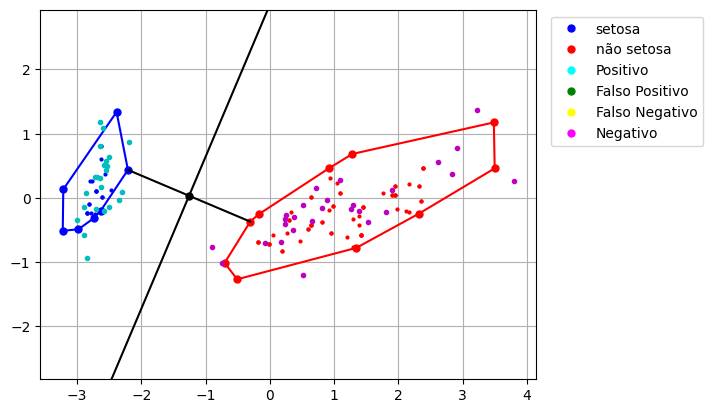

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


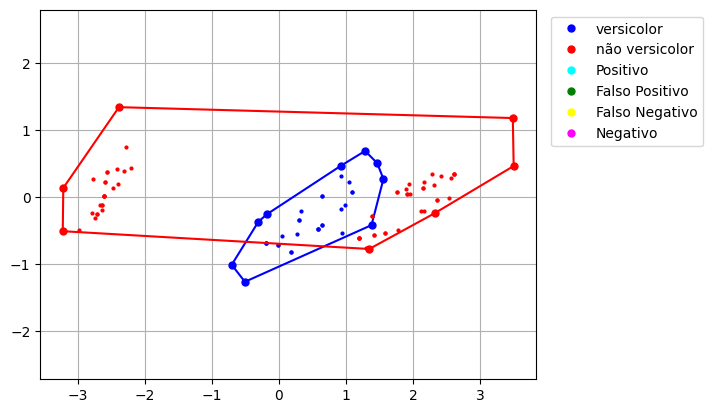

Não linearmente separável


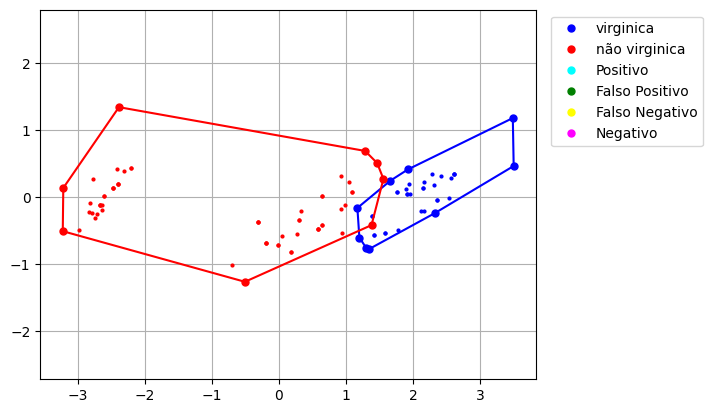

Não linearmente separável


In [312]:
iris = sklearn.datasets.load_iris()
models = testDataset(iris)
for m in models:
	print(m)

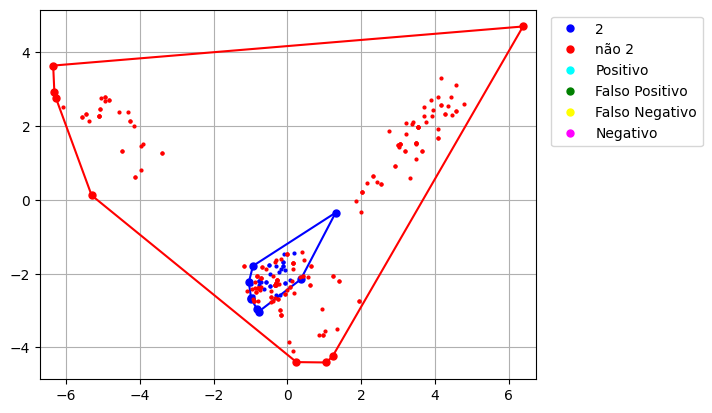

Não linearmente separável


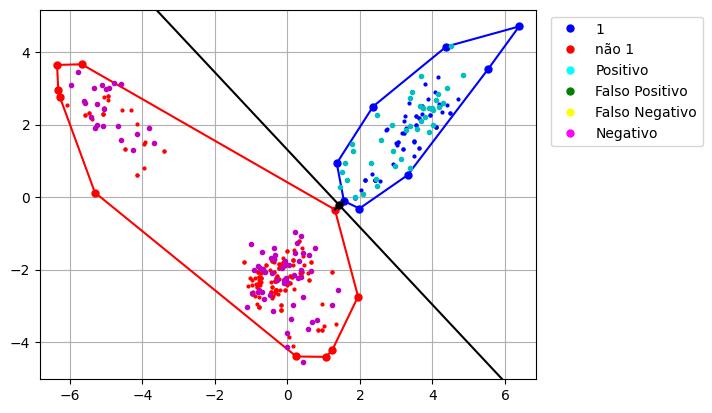

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


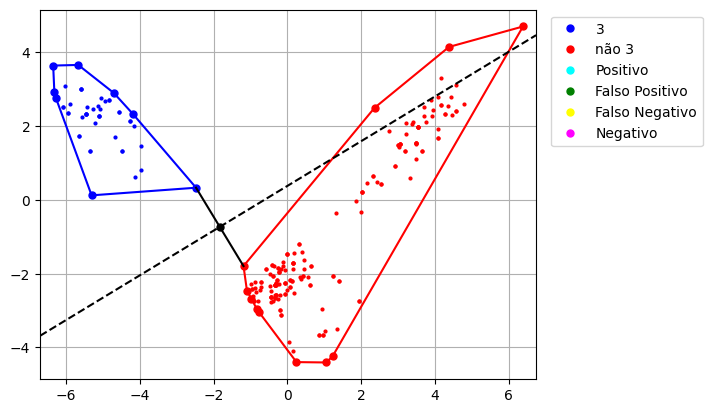

Não linearmente separável


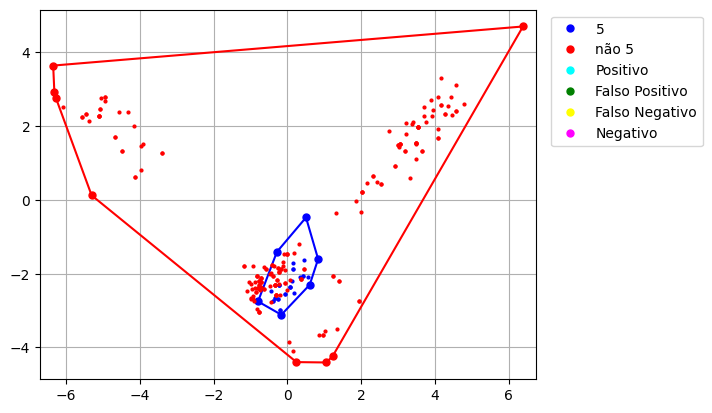

Não linearmente separável


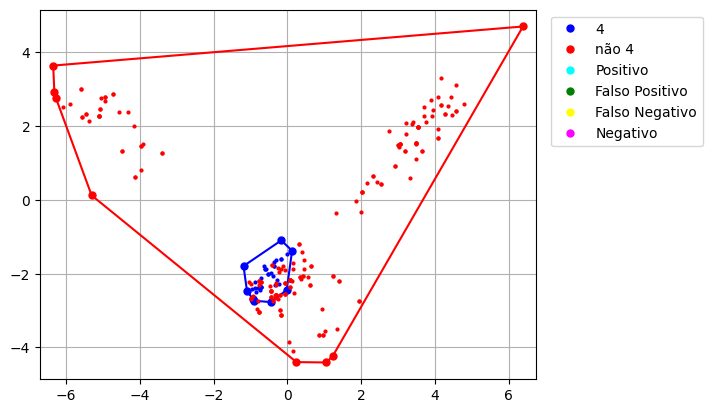

Não linearmente separável


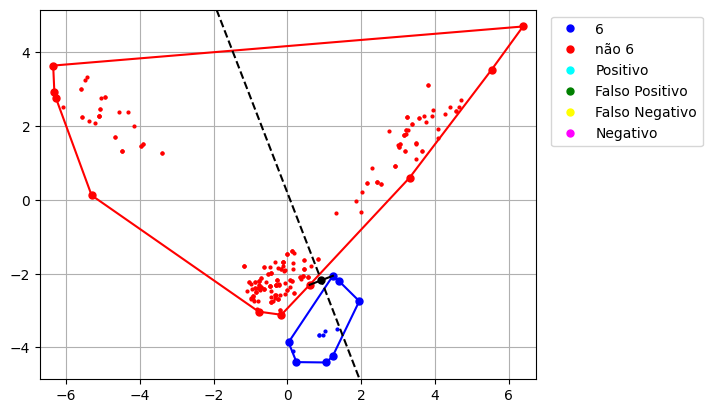

Não linearmente separável


In [313]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/dermatology.prepared.csv'
dermatology = convertCSVFromURL(url)
testData = testDataset(dermatology)
for m in testData:
	print(m)

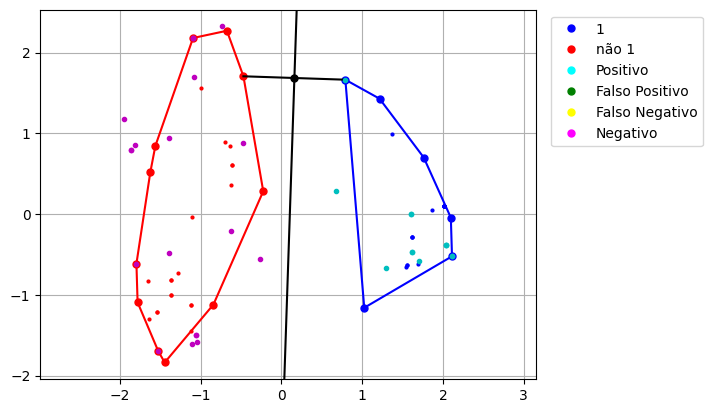

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


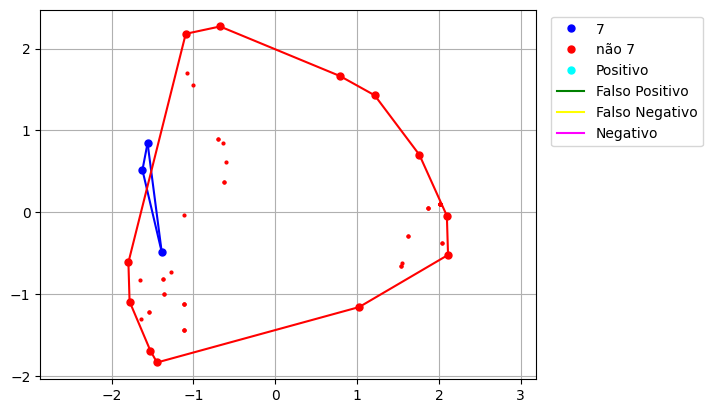

Não linearmente separável


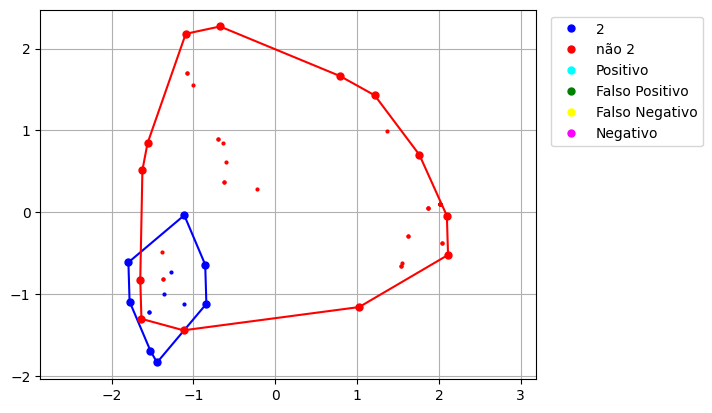

Não linearmente separável


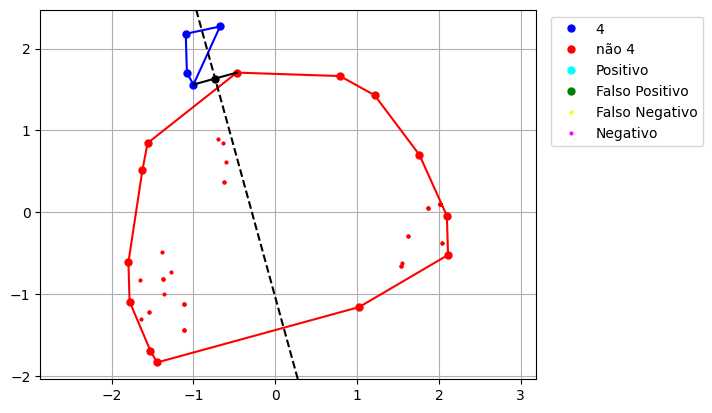

Não linearmente separável


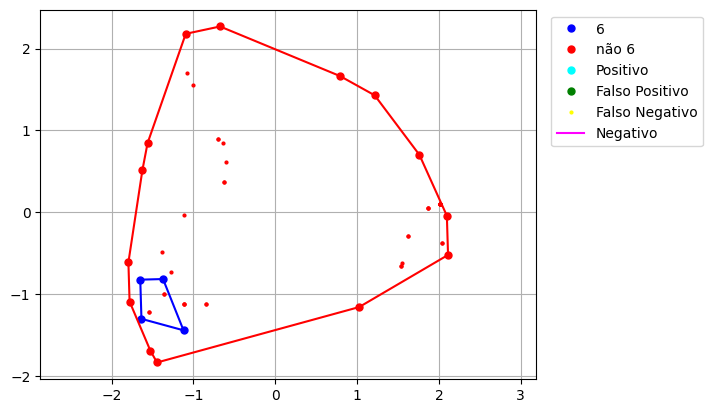

Não linearmente separável


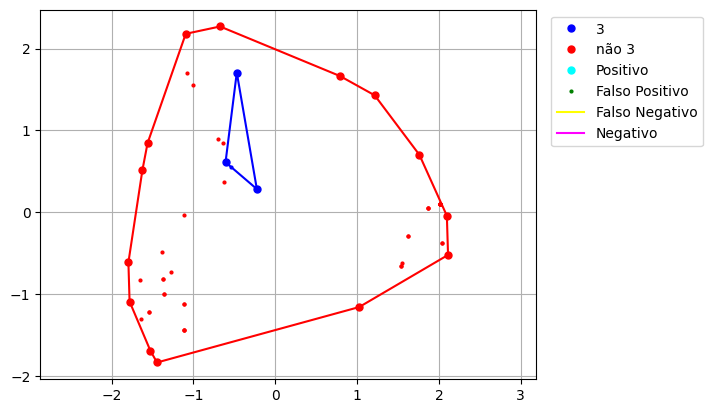

Não linearmente separável


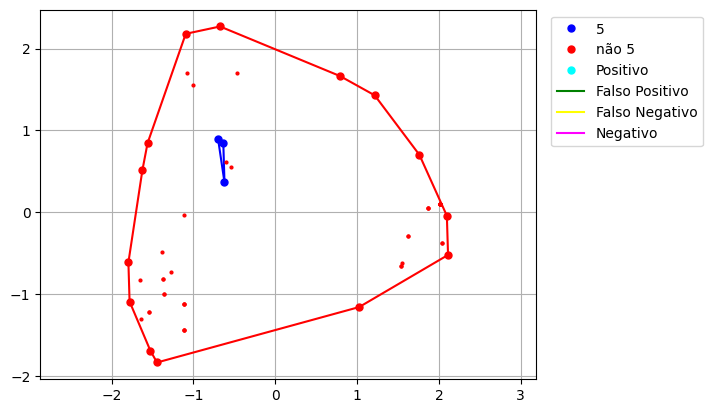

Não linearmente separável


In [314]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/zoo.prepared.csv'
zoo = convertCSVFromURL(url)
testData = testDataset(zoo)
for m in testData:
	print(m)

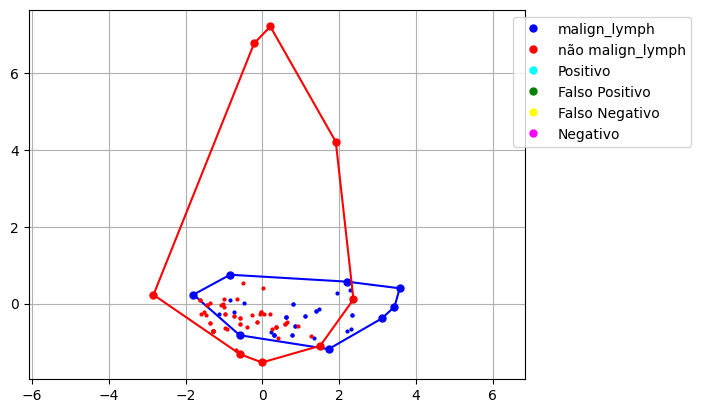

Não linearmente separável


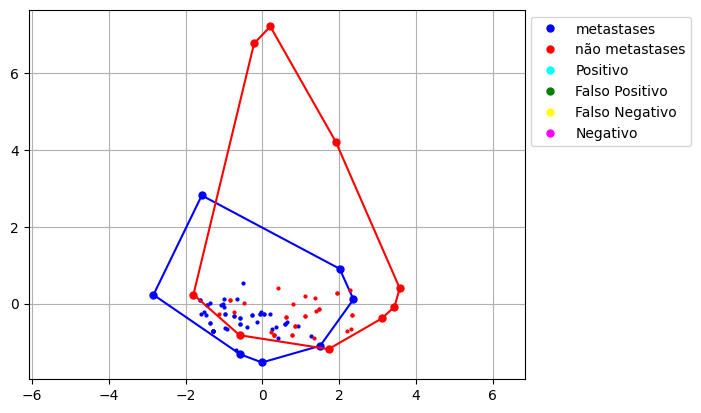

Não linearmente separável


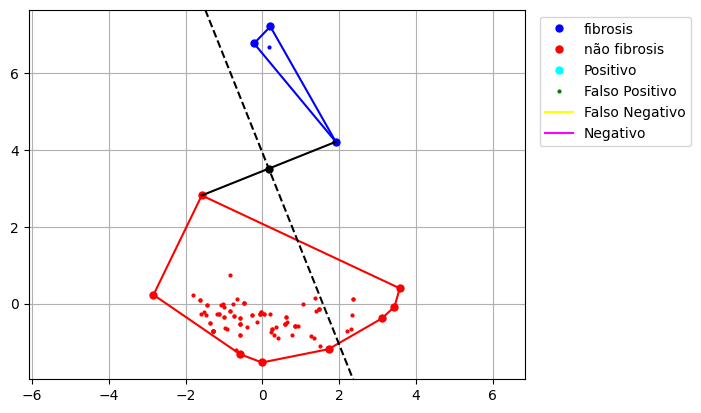

Não linearmente separável


In [315]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/lymphography.prepared.csv'
lymphography = convertCSVFromURL(url)
testData = testDataset(lymphography)
for m in testData:
	print(m)

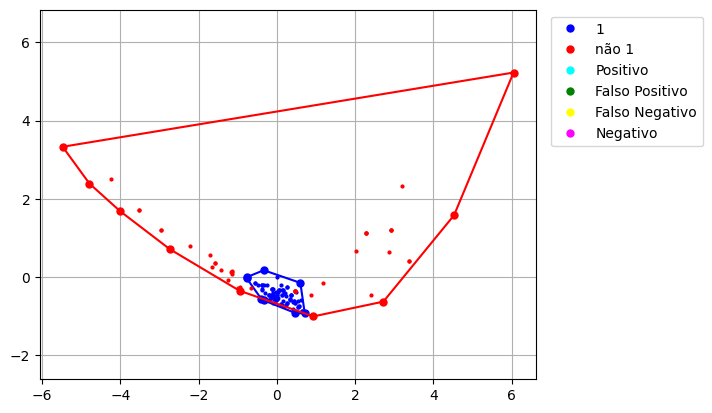

Não linearmente separável


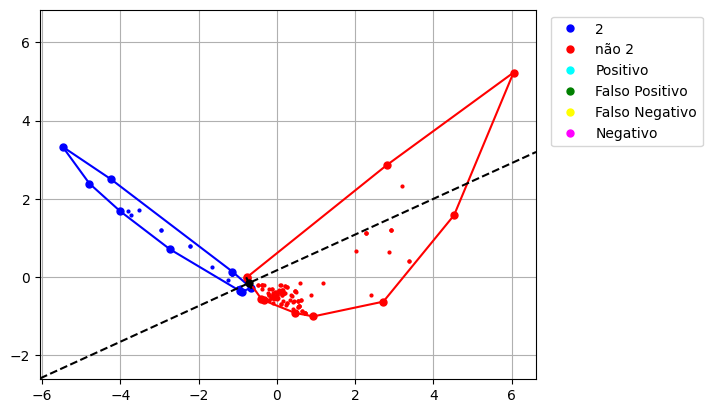

Não linearmente separável


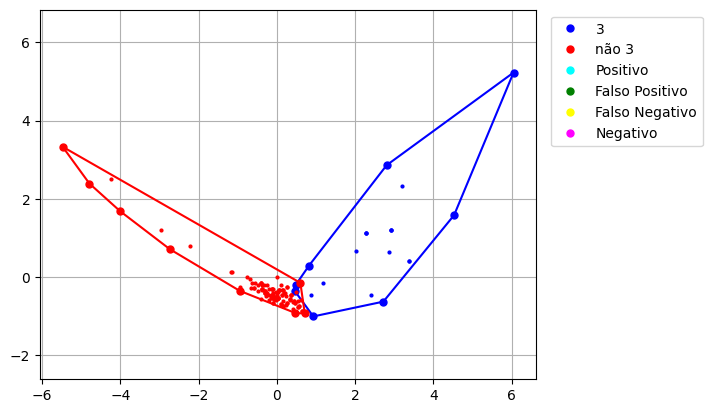

Não linearmente separável


In [316]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/newthyroid.prepared.csv'
newthyroid = convertCSVFromURL(url)
testData = testDataset(newthyroid)
for m in testData:
	print(m)

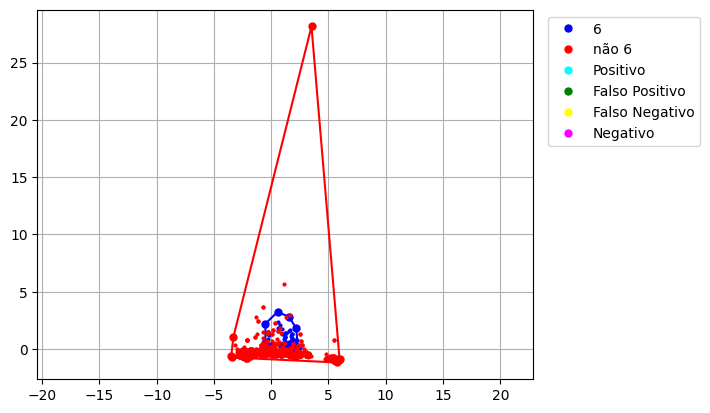

Não linearmente separável


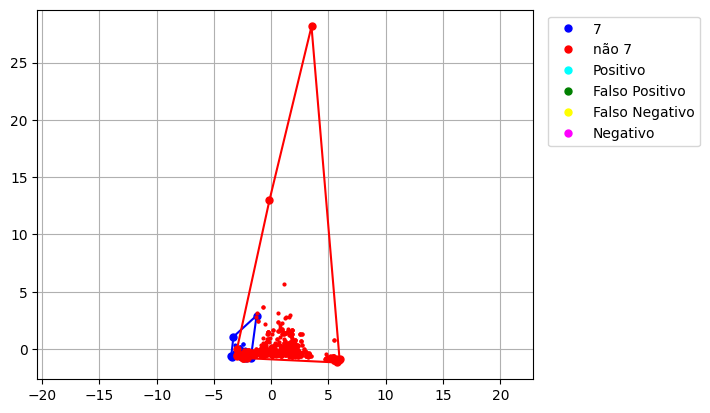

Não linearmente separável


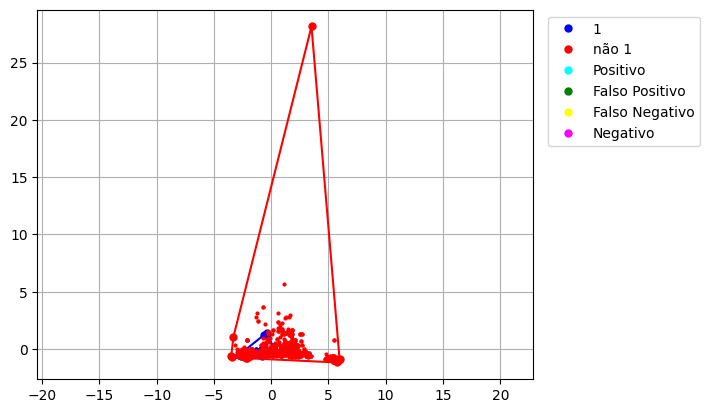

Não linearmente separável


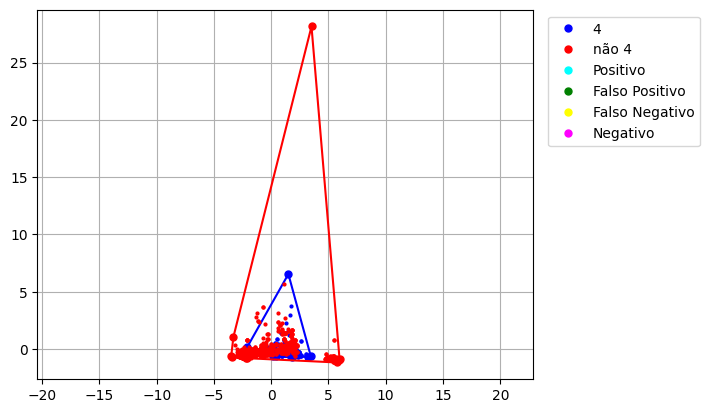

Não linearmente separável


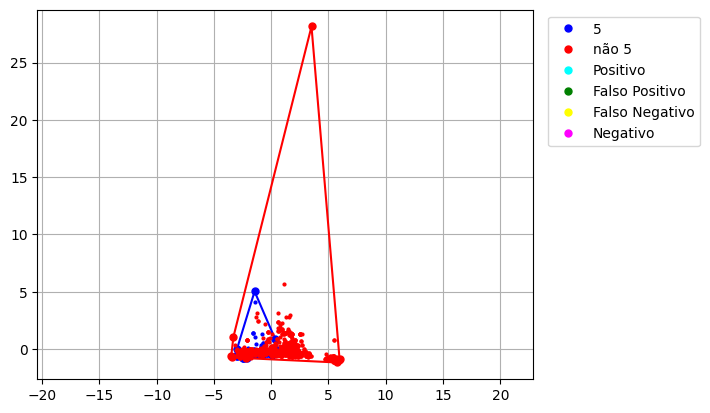

Não linearmente separável


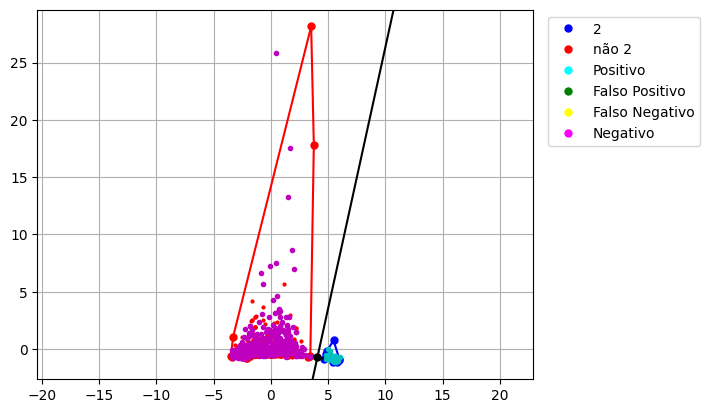

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


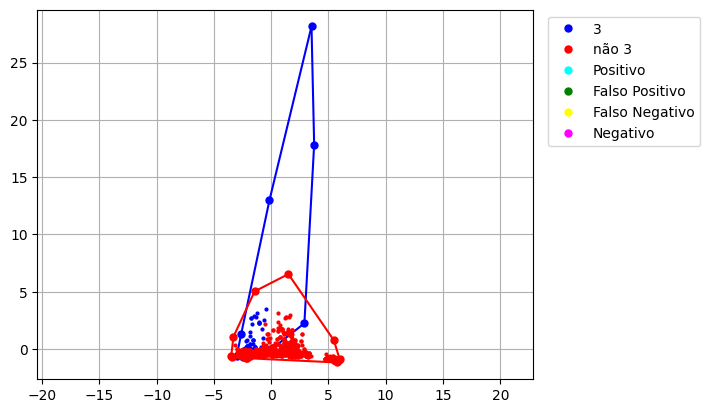

Não linearmente separável


In [317]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv"
segment = convertCSVFromURL(url)
testData = testDataset(segment)
for m in testData:
	print(m)

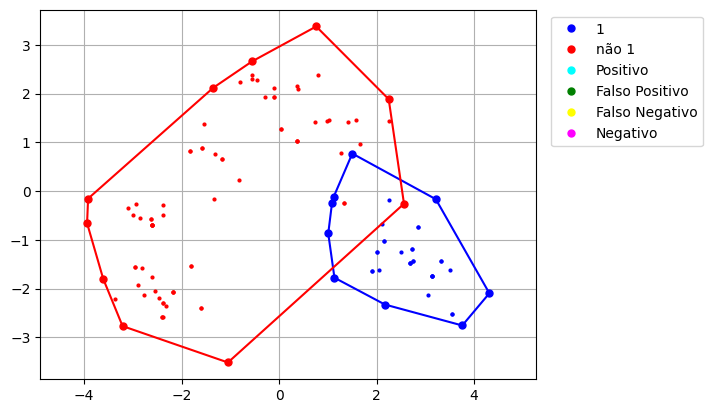

Não linearmente separável


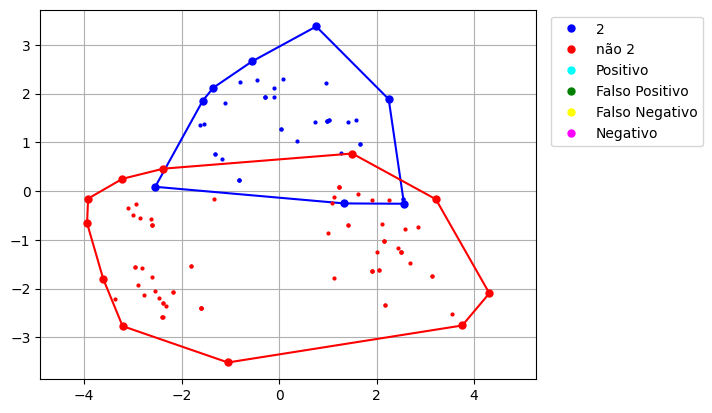

Não linearmente separável


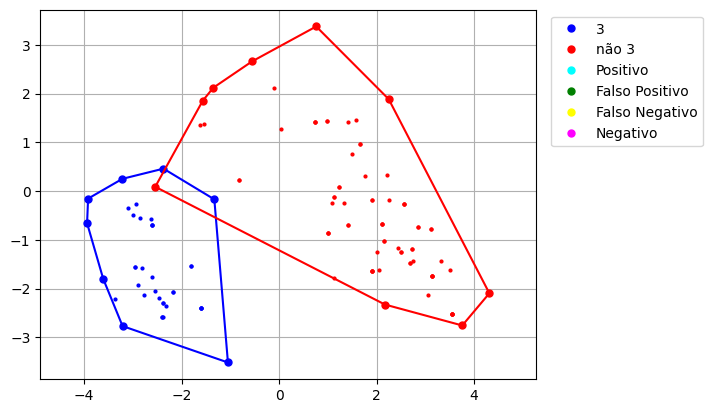

Não linearmente separável


In [318]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/wine.prepared.csv"
wine = convertCSVFromURL(url)
testData = testDataset(wine)
for m in testData:
	print(m)

Cannot create hull with target index imS
Cannot create hull with target index imL


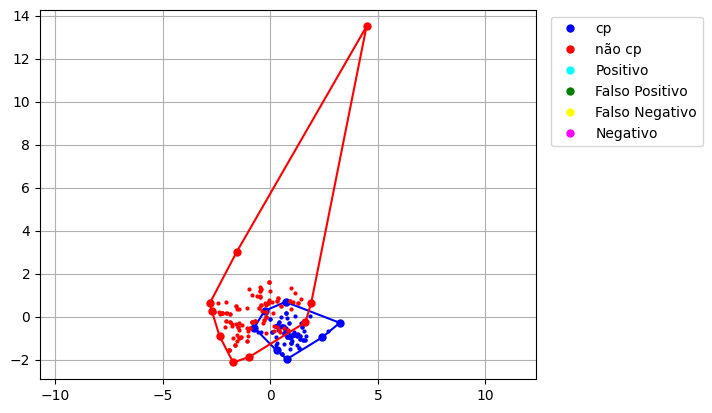

Não linearmente separável


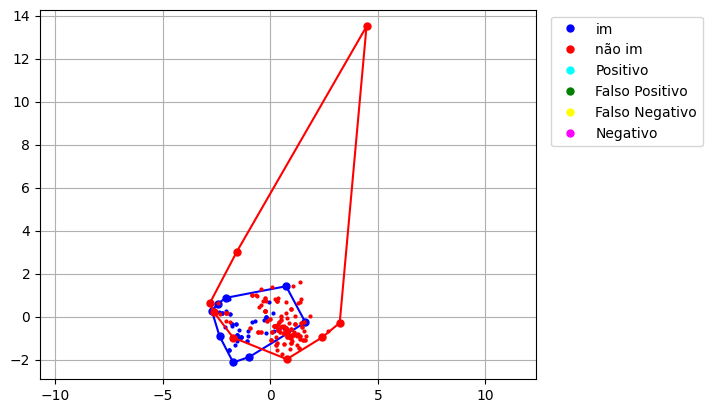

Não linearmente separável


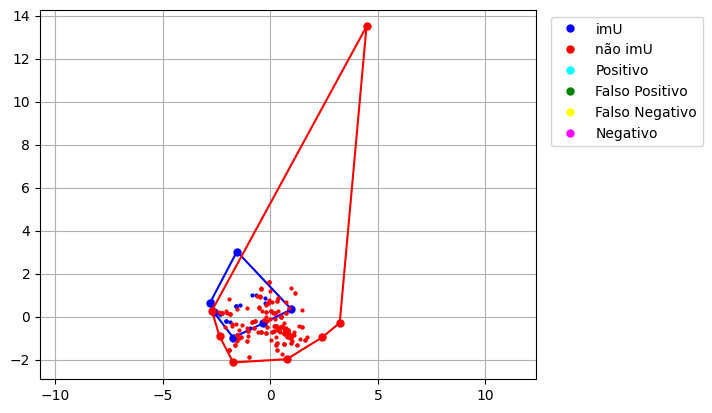

Não linearmente separável


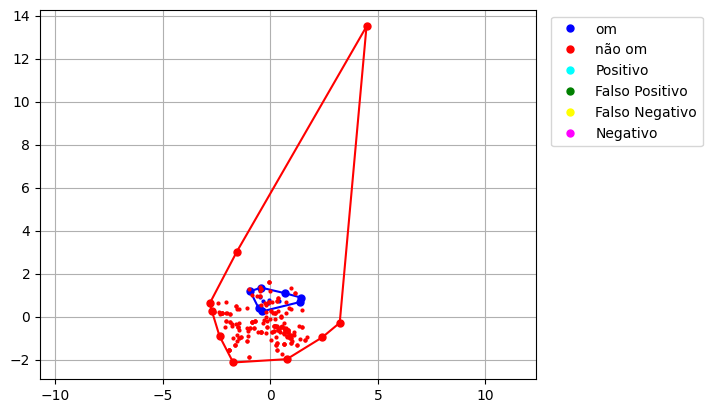

Não linearmente separável


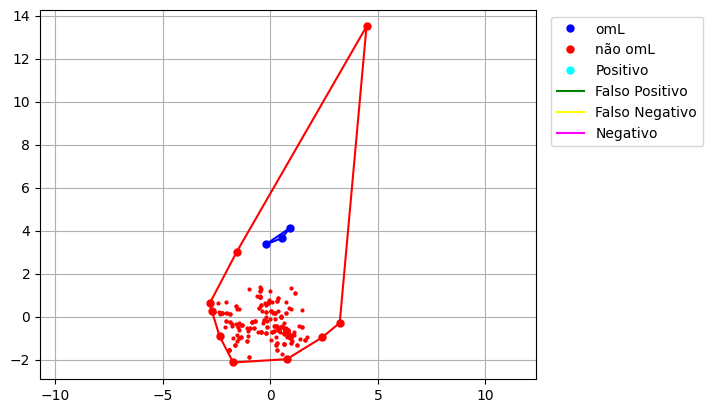

Não linearmente separável


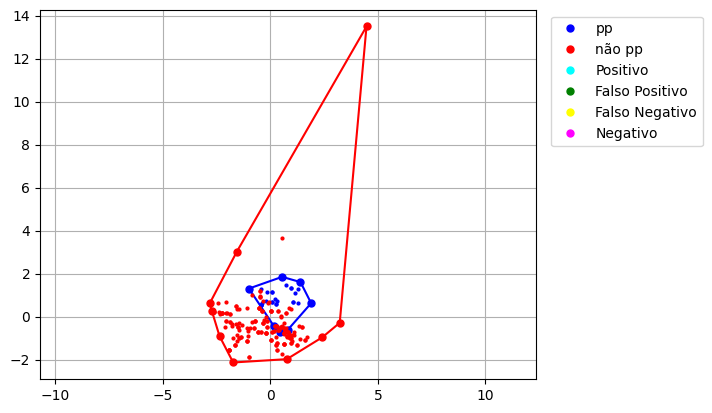

Não linearmente separável


In [319]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/ecoli.prepared.csv'
ecoli = convertCSVFromURL(url)
testData = testDataset(ecoli)
for m in testData:
	print(m)

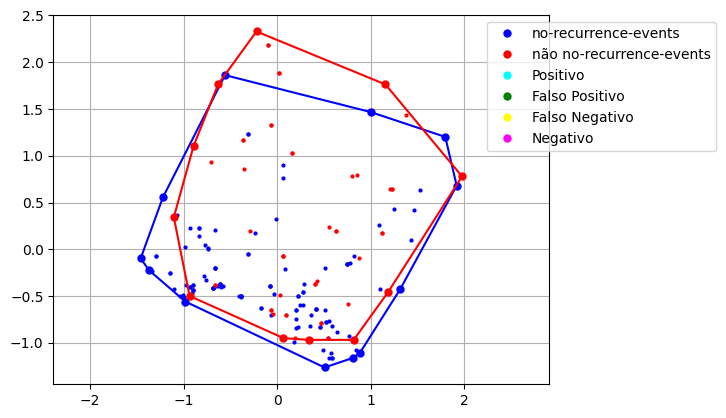

Não linearmente separável


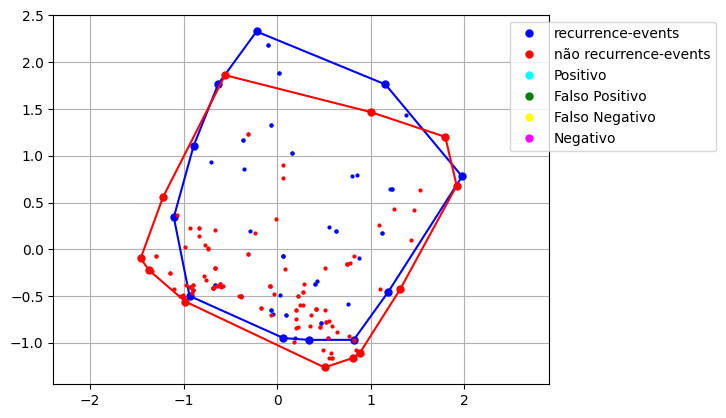

Não linearmente separável


In [320]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/breast.prepared.csv'
breast = convertCSVFromURL(url)
testData = testDataset(breast)
for m in testData:
	print(m)

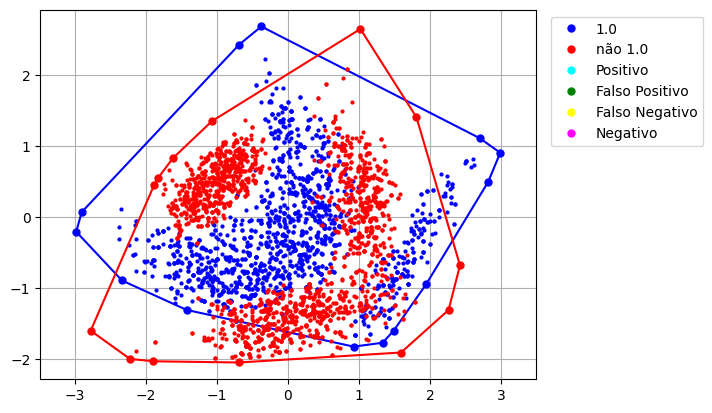

Não linearmente separável


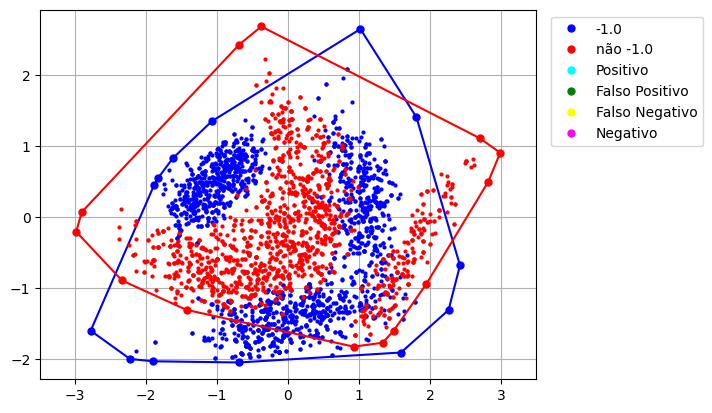

Não linearmente separável


In [321]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/banana.prepared.csv'
banana = convertCSVFromURL(url)
testData = testDataset(banana)
for m in testData:
	print(m)

In [322]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/dermatology.prepared.csv'

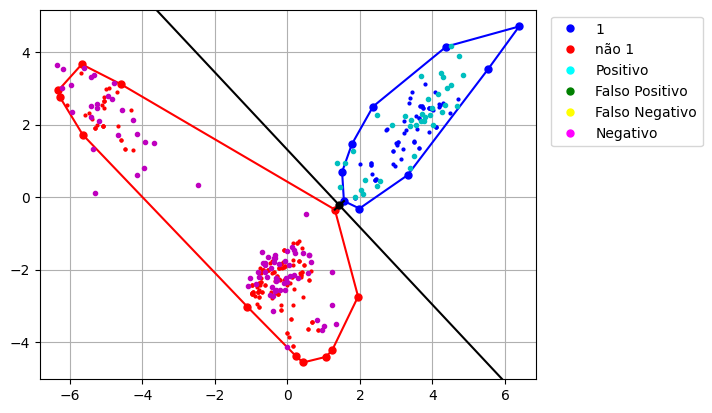

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


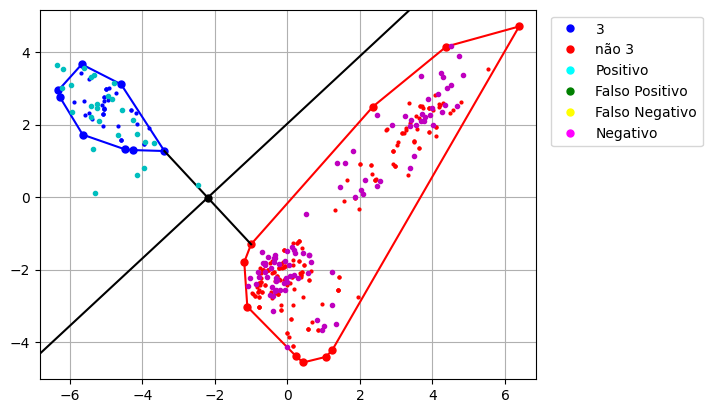

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


In [323]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [324]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/zoo.prepared.csv'

Cannot create hull with target index 3
Cannot create hull with target index 5


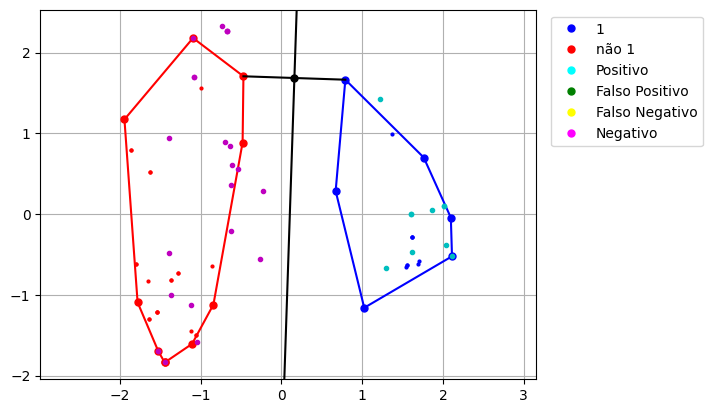

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


In [325]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [326]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/lymphography.prepared.csv'

Cannot create hull with target index normal
Iteration 0 failed
Cannot create hull with target index fibrosis
Cannot create hull with target index normal
Iteration 1 failed
Cannot create hull with target index fibrosis
Cannot create hull with target index normal
Iteration 2 failed
Cannot create hull with target index normal


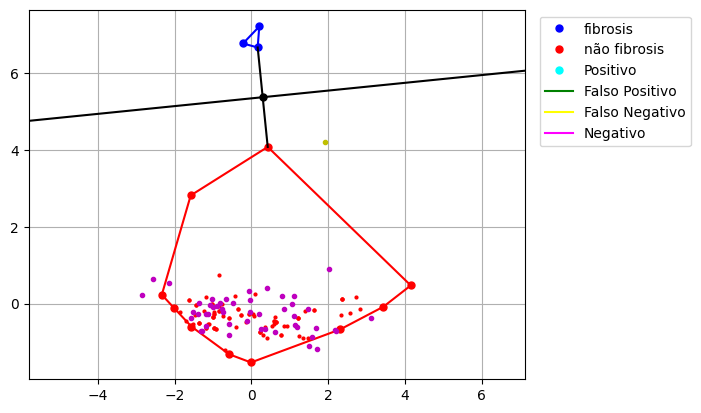

(Precisão: 0, Revocação: 0.0, F1-Score: 0)


In [327]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [328]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/newthyroid.prepared.csv'

Iteration 0 failed
Iteration 1 failed
Iteration 2 failed
Iteration 3 failed
Iteration 4 failed
Iteration 5 failed
Iteration 6 failed
Iteration 7 failed
Iteration 8 failed
Iteration 9 failed
Iteration 10 failed
Iteration 11 failed
Iteration 12 failed
Iteration 13 failed
Iteration 14 failed
Iteration 15 failed
Iteration 16 failed
Iteration 17 failed
Iteration 18 failed
Iteration 19 failed
Iteration 20 failed
Iteration 21 failed
Iteration 22 failed
Iteration 23 failed


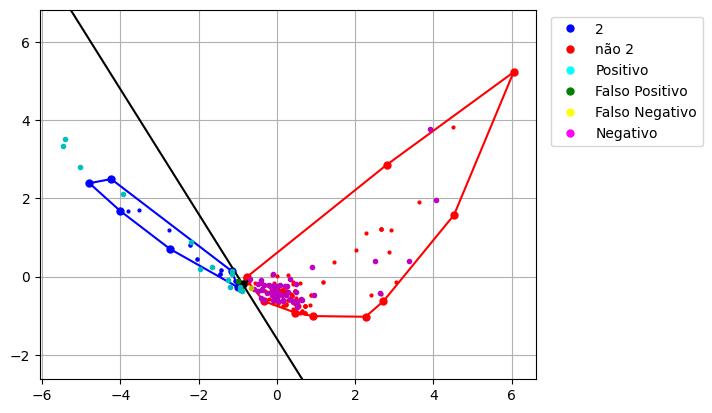

(Precisão: 0.9333333333333333, Revocação: 0.9333333333333333, F1-Score: 0.9333333333333333)


In [329]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [330]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/segment.prepared.csv"

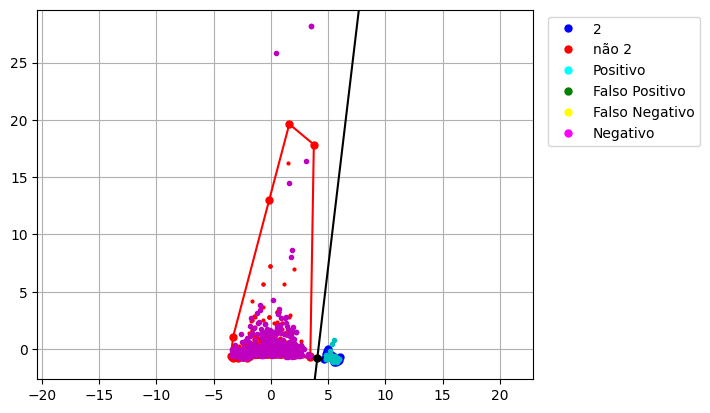

(Precisão: 1.0, Revocação: 1.0, F1-Score: 1.0)


In [331]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [332]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/wine.prepared.csv"

Iteration 0 failed
Iteration 1 failed
Iteration 2 failed


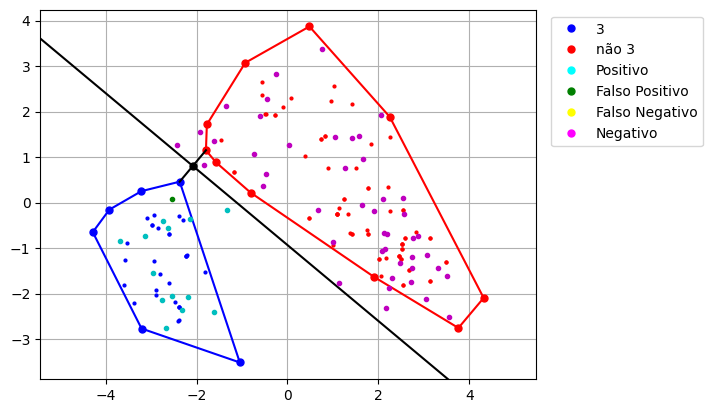

(Precisão: 0.9285714285714286, Revocação: 1.0, F1-Score: 0.962962962962963)


In [333]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [334]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/ecoli.prepared.csv'

Cannot create hull with target index imS
Cannot create hull with target index imL
Iteration 0 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Iteration 1 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Cannot create hull with target index omL
Iteration 2 failed
Cannot create hull with target index imL
Iteration 3 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Iteration 4 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Iteration 5 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Iteration 6 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Cannot create hull with target index omL
Iteration 7 failed
Cannot create hull with target index imS
Cannot create hull with target index imL
Cannot create hull with target index omL
Iteration 8 failed
Cannot cr

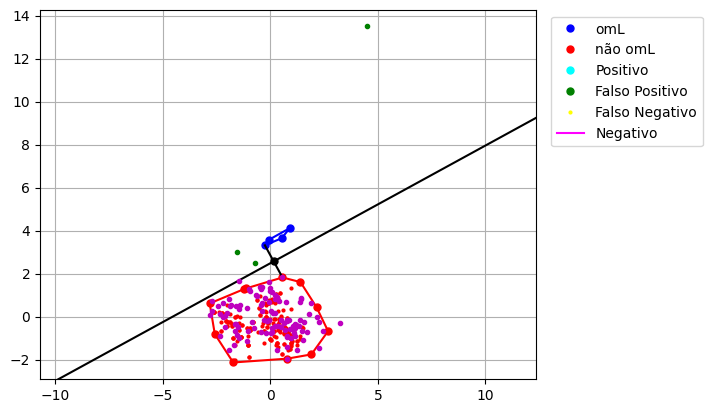

(Precisão: 0.0, Revocação: 0, F1-Score: 0)


In [335]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

In [336]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/breast.prepared.csv'

In [337]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

Iteration 0 failed
Iteration 1 failed
Iteration 2 failed
Iteration 3 failed
Iteration 4 failed
Iteration 5 failed
Iteration 6 failed
Iteration 7 failed
Iteration 8 failed
Iteration 9 failed
Iteration 10 failed
Iteration 11 failed
Iteration 12 failed
Iteration 13 failed
Iteration 14 failed
Iteration 15 failed
Iteration 16 failed
Iteration 17 failed
Iteration 18 failed
Iteration 19 failed
Iteration 20 failed
Iteration 21 failed
Iteration 22 failed
Iteration 23 failed
Iteration 24 failed
Iteration 25 failed
Iteration 26 failed
Iteration 27 failed
Iteration 28 failed
Iteration 29 failed
Iteration 30 failed
Iteration 31 failed
Iteration 32 failed
Iteration 33 failed
Iteration 34 failed
Iteration 35 failed
Iteration 36 failed
Iteration 37 failed
Iteration 38 failed
Iteration 39 failed
Iteration 40 failed
Iteration 41 failed
Iteration 42 failed
Iteration 43 failed
Iteration 44 failed
Iteration 45 failed
Iteration 46 failed
Iteration 47 failed
Iteration 48 failed
Iteration 49 failed
Iteration 

In [338]:
url = 'https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/onehot/banana.prepared.csv'

In [339]:
models = findLinearlySeparableFromURL(url)
if models != None:
	for m in models:
		if m.isLinearlySeparable:
			print(m)

Iteration 0 failed
Iteration 1 failed
Iteration 2 failed
Iteration 3 failed
Iteration 4 failed
Iteration 5 failed
Iteration 6 failed
Iteration 7 failed
Iteration 8 failed
Iteration 9 failed
Iteration 10 failed
Iteration 11 failed
Iteration 12 failed
Iteration 13 failed
Iteration 14 failed
Iteration 15 failed
Iteration 16 failed
Iteration 17 failed
Iteration 18 failed
Iteration 19 failed
Iteration 20 failed
Iteration 21 failed
Iteration 22 failed
Iteration 23 failed
Iteration 24 failed
Iteration 25 failed
Iteration 26 failed
Iteration 27 failed
Iteration 28 failed
Iteration 29 failed
Iteration 30 failed
Iteration 31 failed
Iteration 32 failed
Iteration 33 failed
Iteration 34 failed
Iteration 35 failed
Iteration 36 failed
Iteration 37 failed
Iteration 38 failed
Iteration 39 failed
Iteration 40 failed
Iteration 41 failed
Iteration 42 failed
Iteration 43 failed
Iteration 44 failed
Iteration 45 failed
Iteration 46 failed
Iteration 47 failed
Iteration 48 failed
Iteration 49 failed
Iteration 